In [4]:
!pip install torchinfo torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 7.5 MB/s eta 0:00:00


In [5]:
import os
import numbers
import random
import numpy as np
from PIL import Image
from enum import IntEnum
from typing import Sequence
import matplotlib.pyplot as plt


import torch
import torchvision
from torch import nn
from torchinfo import summary
import torchmetrics as TM
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

In [6]:
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [7]:
tensor_to_pil_image_transform = transforms.ToPILImage()
pil_to_tensor_image_transform = transforms.ToTensor()

In [8]:
def save_model_checkpoint(model, checkpoint_name):
    torch.save(model, os.path.join(os.getcwd(), checkpoint_name))


def get_device():
    if torch.cuda.is_available():
        # print(f"total cuda device count: {torch.cuda.device_count()}")
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def load_model_checkpoint(checkpoint_name):
    return torch.load(checkpoint_name, map_location=get_device())


def get_model_parameters_count(parameter_reference):
    return sum(param.numel() for param in parameter_reference.parameters())


def trimap2float(trimap):
    return (pil_to_tensor_image_transform(trimap) * 255.0 - 1) / 2


def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x


def args_to_dict(**kwargs):
    return kwargs


def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

In [9]:
data_train_path = os.path.join(os.getcwd(), "data_folder", "train")
data_test_path = os.path.join(os.getcwd(), "data_folder", "test")

should_download = False if os.path.exists(data_train_path) else True

train_dataset = torchvision.datasets.OxfordIIITPet(
    root=data_train_path,
    split="trainval",
    target_types="segmentation",
    download=should_download,
)

test_dataset = torchvision.datasets.OxfordIIITPet(
    root=data_test_path,
    split="test",
    target_types="segmentation",
    download=should_download,
)

100%|██████████| 791918971/791918971 [00:57<00:00, 13807924.81it/s]


Extracting /content/data_folder/train/oxford-iiit-pet/images.tar.gz to /content/data_folder/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7121787.15it/s] 


Extracting /content/data_folder/train/oxford-iiit-pet/annotations.tar.gz to /content/data_folder/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:57<00:00, 13770299.09it/s]


Extracting /content/data_folder/test/oxford-iiit-pet/images.tar.gz to /content/data_folder/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7205020.99it/s] 


Extracting /content/data_folder/test/oxford-iiit-pet/annotations.tar.gz to /content/data_folder/test/oxford-iiit-pet


In [10]:
print(train_dataset, test_dataset)

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: /content/data_folder/train Dataset OxfordIIITPet
    Number of datapoints: 3669
    Root location: /content/data_folder/test


In [11]:
image, target = train_dataset[0]

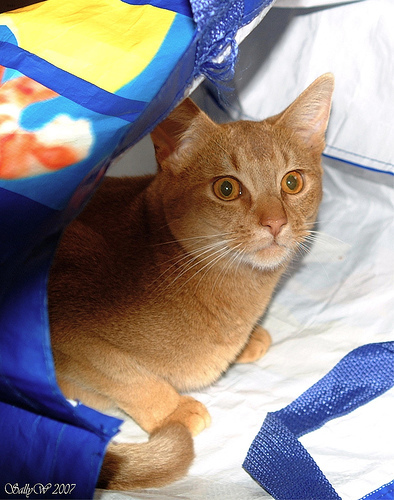

In [12]:
image

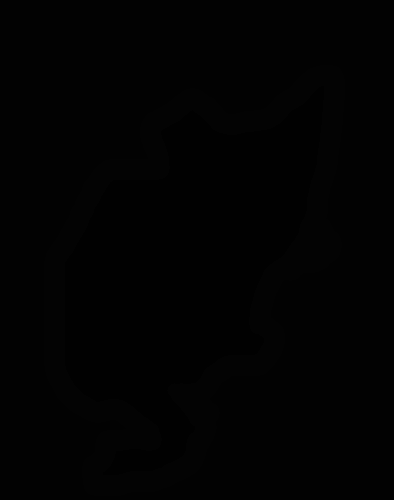

In [13]:
target

In [14]:
class TrimapClasses(IntEnum):
    INSTANCE = 0
    BACKGROUND = 1
    BORDER = 2

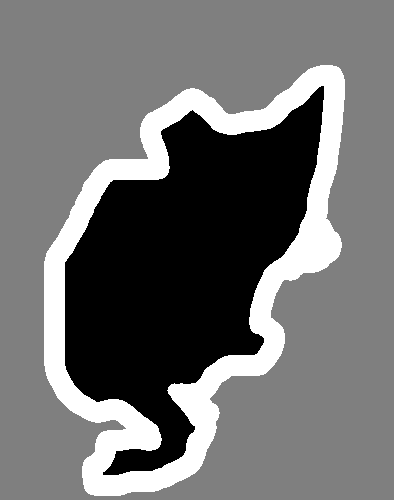

In [15]:
tensor_to_pil_image_transform(trimap2float(target))

In [16]:
class ToDevice(nn.Module):
    def __init__(self, device):
        super(ToDevice, self).__init__()
        self.device = device

    def forward(self, image):
        return image.to(self.device)

    def __repr__(self):
        return f"{self.__class__.__name__}(device={self.device})"

In [17]:
ToDevice(get_device())

ToDevice(device=cuda)

In [18]:
class DatasetAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root,
        split,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transforms=None,
    ):
        super(DatasetAugmented, self).__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transforms = common_transforms

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        input, target = super().__getitem__(idx)
        if self.common_transforms is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transforms(both)
            input, target = torch.split(both, 3, dim=0)
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)
        return (input, target)

In [19]:
transform_dict = args_to_dict(
    pre_transform=transforms.ToTensor(),
    pre_target_transform=transforms.ToTensor(),
    common_transforms=transforms.Compose(
        [
            ToDevice(get_device()),
            transforms.Resize(
                size=(128, 128), interpolation=transforms.InterpolationMode.NEAREST
            ),
            transforms.RandomHorizontalFlip(p=0.5),
        ]
    ),
    post_transform=transforms.Compose(
        [
            transforms.ColorJitter(contrast=0.3),
        ]
    ),
    post_target_transform=transforms.Compose([transforms.Lambda(tensor_trimap)]),
)

In [20]:
transform_dict

{'pre_transform': ToTensor(),
 'pre_target_transform': ToTensor(),
 'common_transforms': Compose(
     ToDevice(device=cuda)
     Resize(size=(128, 128), interpolation=nearest, max_size=None, antialias=warn)
     RandomHorizontalFlip(p=0.5)
 ),
 'post_transform': Compose(
     ColorJitter(brightness=None, contrast=(0.7, 1.3), saturation=None, hue=None)
 ),
 'post_target_transform': Compose(
     Lambda()
 )}

In [21]:
processed_train_dataset = DatasetAugmented(
    root=data_train_path,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

processed_test_dataset = DatasetAugmented(
    root=data_test_path,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

In [22]:
input, target = processed_test_dataset[0]

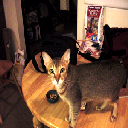

In [23]:
tensor_to_pil_image_transform(input)

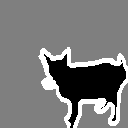

In [24]:
tensor_to_pil_image_transform(target.to(torch.float32) / 2.0)

In [25]:
train_dataloader = DataLoader(
    processed_train_dataset,
    batch_size=64,
    shuffle=True,
)

test_dataloader = DataLoader(
    processed_test_dataset,
    batch_size=21,
    shuffle=True,
)

In [50]:
(train_inputs, train_targets) = next(iter(train_dataloader))
(test_inputs, test_targets) = next(iter(test_dataloader))
train_inputs.shape, train_targets.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

In [27]:
input_data_grid = torchvision.utils.make_grid(train_inputs, nrow=8)
tensor_to_pil_image_transform(input_data_grid)

Output hidden; open in https://colab.research.google.com to view.

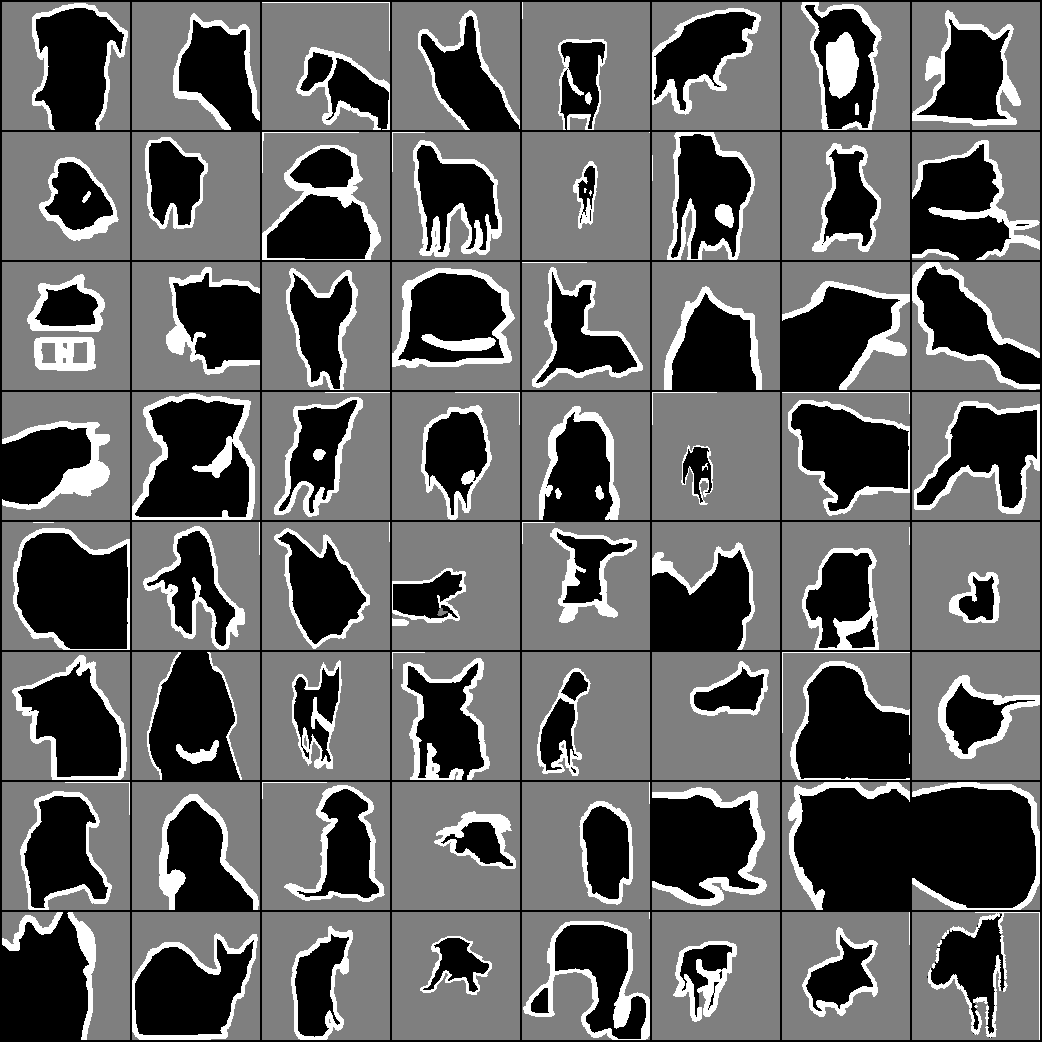

In [28]:
target_data_grid = torchvision.utils.make_grid(train_targets / 2.0, nrow=8)
tensor_to_pil_image_transform(target_data_grid)

In [29]:
class DownConv2(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size):
        super(DownConv2, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_in,
                out_channels=channel_out,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=channel_out,
                out_channels=channel_out,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
        )
        self.max_pool = nn.MaxPool2d(
            kernel_size=2,
            return_indices=True,
        )

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.max_pool(y)
        return y, indices, pool_shape


class DownConv3(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size):
        super(DownConv3, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_in,
                out_channels=channel_out,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=channel_out,
                out_channels=channel_out,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=channel_out,
                out_channels=channel_out,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
        )
        self.max_pool = nn.MaxPool2d(
            kernel_size=2,
            return_indices=True,
        )

    def forward(self, x):
        y = self.seq(x)
        pool_shape = y.shape
        y, indices = self.max_pool(y)
        return y, indices, pool_shape

In [30]:
class UpConv2(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size):
        super(UpConv2, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_in,
                out_channels=channel_in,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_in),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=channel_in,
                out_channels=channel_out,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
        )
        self.max_pool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.max_pool(x, indices, output_size=output_size)
        y = self.seq(y)
        return y


class UpConv3(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size):
        super(UpConv3, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_in,
                out_channels=channel_in,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_in),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=channel_in,
                out_channels=channel_in,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_in),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=channel_in,
                out_channels=channel_out,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,
                bias=False,
            ),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(),
        )
        self.max_pool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        y = self.max_pool(x, indices, output_size=output_size)
        y = self.seq(y)
        return y

In [31]:
class ImageSegmentation(nn.Module):
    def __init__(self, kernel_size):
        super(ImageSegmentation, self).__init__()
        self.out_channels = 3
        self.batch_norm = nn.BatchNorm2d(self.out_channels)
        self.dc1 = DownConv2(3, 64, kernel_size)
        self.dc2 = DownConv2(64, 128, kernel_size)
        self.dc3 = DownConv3(128, 256, kernel_size)
        self.dc4 = DownConv3(256, 512, kernel_size)

        self.uc4 = UpConv3(512, 256, kernel_size)
        self.uc3 = UpConv3(256, 128, kernel_size)
        self.uc2 = UpConv2(128, 64, kernel_size)
        self.uc1 = UpConv2(64, 3, kernel_size)

    def forward(self, batch):
        x = self.batch_norm(batch)
        x, mp1_indices, shape1 = self.dc1(x)
        x, mp2_indices, shape2 = self.dc2(x)
        x, mp3_indices, shape3 = self.dc3(x)
        x, mp4_indices, shape4 = self.dc4(x)

        x = self.uc4(x, mp4_indices, shape4)
        x = self.uc3(x, mp3_indices, shape3)
        x = self.uc2(x, mp2_indices, shape2)
        x = self.uc1(x, mp1_indices, shape1)

        return x

In [32]:
model = ImageSegmentation(kernel_size=3)
model.to(get_device())

ImageSegmentation(
  (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dc1): DownConv2(
    (seq): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dc2): DownConv2(
    (seq): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): Ba

In [57]:
def IoUMetric(predictions, ground_truths, softmax=False):
    if softmax:
        predictions = nn.Softmax(dim=1)(predictions)
    ground_truths = torch.cat([(ground_truths == i) for i in range(3)], dim=1)
    intersection = ground_truths * predictions
    union = ground_truths + predictions - intersection
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    return iou.mean()

In [58]:
class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super(IoULoss, self).__init__()
        self.softmax = softmax

    def forward(self, predictions, ground_truths):
        return -(IoUMetric(predictions, ground_truths, self.softmax).log())

In [59]:
def train_model(model, loader, optimizer):
    model.train()
    criterion = nn.CrossEntropyLoss(reduction="mean")
    # criterion = IoULoss(softmax=True)
    running_loss = 0.0
    running_samples = 0
    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(get_device())
        targets = targets.to(get_device())
        outputs = model(inputs)
        targets = targets.squeeze(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_samples += targets.size(0)
        running_loss += loss.item()
    print(f"trained {running_samples} samples | loss: {running_loss/(batch_idx+1)}")

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)
train_model(model, train_dataloader, optimizer)

trained 3680 samples | loss: 0.6992377361346935


In [61]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()


def print_test_dataset_masks(
    model, test_targets, test_labels, epoch, save_path, show_plot
):
    model.eval()
    test_targets = test_targets.to(get_device())
    test_labels = test_labels.to(get_device())
    predictions = model(test_targets)
    predictions = nn.Softmax(dim=1)(predictions)
    pred_labels = predictions.argmax(dim=1)
    pred_labels = pred_labels.unsqueeze(1)
    pred_mask = pred_labels.to(torch.float16)
    iou = TM.classification.MulticlassJaccardIndex(
        3, average='micro', ignore_index=TrimapClasses.BACKGROUND
    ).to(get_device())
    iou_accuracy = iou(pred_mask, test_labels)
    pixel_metric = TM.classification.MulticlassAccuracy(3, average='micro').to(get_device())
    pixel_accuracy = pixel_metric(pred_labels, test_labels)
    custom_iou = IoUMetric(predictions, test_labels)
    title = f"Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]"
    print(title)

    close_figures()
    fig = plt.figure(figsize=(6, 12))
    fig.suptitle(title, fontsize=10)
    fig.add_subplot(3, 1, 1)
    plt.imshow(tensor_to_pil_image_transform(torchvision.utils.make_grid(test_targets, nrow=7)))
    plt.axis("off")
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(
        tensor_to_pil_image_transform(torchvision.utils.make_grid(test_labels.float() / 2.0, nrow=7))
    )
    plt.axis("off")
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(tensor_to_pil_image_transform(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis("off")
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(
            os.path.join(save_path, f"epoch_{epoch:02}.png"),
            format="png",
            bbox_inches="tight",
            pad_inches=0.4,
        )

    if show_plot is False:
        close_figures()
    else:
        plt.show()

In [62]:
def test_accuracy(model, loader):
    iou = TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND).to(get_device())
    pixel_metric = TM.classification.MulticlassAccuracy(3, average='micro').to(get_device())

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = inputs.to(get_device())
        targets = targets.to(get_device())
        predictions = model(inputs)
        pred_probabs = nn.Softmax(dim=1)(predictions)
        pred_labels = pred_probabs.argmax(dim=1)
        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float16)
        iou_accuracy = iou(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou_accuracy = IoUMetric(pred_probabs, targets)

        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou_accuracy.item())

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")


Epoch: 00, Accuracy[Pixel: 0.6991, IoU: 0.5261, Custom IoU: 0.3933]


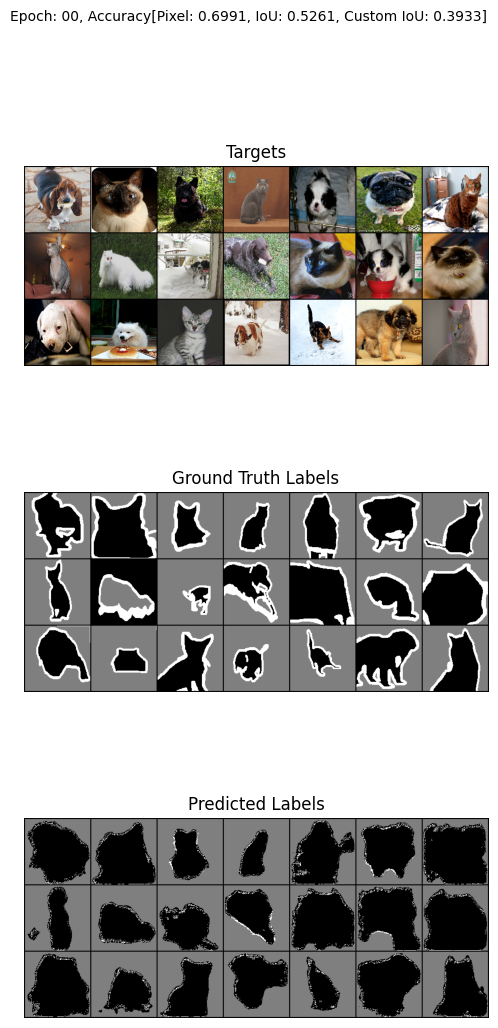

In [63]:
save_path = os.path.join(os.getcwd(), "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(model, test_inputs, test_targets, epoch=0, save_path=None, show_plot=True)

In [64]:
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
    test_inputs, test_targets = test_data
    for i in range(1, epochs):
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        with torch.inference_mode():
            print_test_dataset_masks(model, test_inputs, test_targets, i, save_path, show_plot=True)
        if scheduler is not None:
            scheduler.step()
        print()

In [65]:
save_path = os.path.join(os.getcwd(), "segnet_basic_training_progress_images")
train_loop(model, train_dataloader, (test_inputs, test_targets), 21, optimizer, scheduler, save_path)

Output hidden; open in https://colab.research.google.com to view.

In [66]:
get_model_parameters_count(model)

15274892

In [67]:
save_model_checkpoint(model, f"pets_segnet_CrossEntropyLoss_LRSchedule_20_epochs.pth")